# Introduction to Random Forests - Beginner

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Clarke, Kaustav Das
* Version: 4.0.1

# Introduction

Recall that machine learning models suffer from two types of errors:
* Bias: This is the error in the model due to incorrect assumptions, e.g., assuming the data is linear when it is 
  actually quadratic. A high bias model typically underfits the data.
* Variance: This is the error due to sensitivity to small variations in the training data, e.g., fitting a 
  high-degree polynomial to the training data. A high variance model typically overfits the data.
Increasing the complexity of a model will typically reduce the bias and increase the variance. The optimal complexity will then be at the point where the combination of these errors is a minimum.

In the last notebook we considered Decision Tree Classifiers (DTC), and showed that, although they are very fast, they have a tendency to overfit the training data and therefore have a high variance. This can be overcome by using cross-validation to search for the optimal hyper-parameters of the DTC, e.g., `min_samples_leaf`. However, generally this is overcome by running a series or ensemble of DTC on random combinations of the training set and aggregating these to create a more accurate classifier. This is the concept behind Random Forest Classifiers (RFC). These typically have similar bias to the underlying DTC, but have significantly lower variance. Consequently, RFC are generally at least as accurate as the best performing members of the DTC ensemble. For general classifiers the resulting model from running an ensemble of simpler models is referred to as an *aggregator*.

In this activity we will investigate how simple ensembles can be created, the different forms of voting that can be used for aggregators, and the basic ideas of how to implement a RFC.

Before we start, you will need to download the following and put them in your local directory:

- [wine_data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Decision-Trees/wine_data.csv)
- [Logit plots module](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Decision-Trees/logitplots.py)

Import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # import the LogisticRegression model

import warnings
warnings.filterwarnings('ignore') # suppress warnings

Import the function for plotting decision boundaries.

In [3]:
from logitplots import plt_decision_boundaries

## Contents

* Ensemble Predictions
* Voting Classifiers and Decision Tress
* Random Forests
* Feature Importance
* Exercises

## Ensemble Predictions

Consider the random tossing of a slightly biased coin that has a 51% probability of turning up heads and a 49% probability of turning up tails. If we count the ratio of heads to total tosses, after a sufficiently large number of tosses this should approach 0.51. The figure below shows this ratio for 10 biased coin tosses up to 1000 tosses as coloured lines. As is apparent the *law of large numbers* shows that for each of the 10 tosses this ratio slowly approaches 0.51. We can also take the average of the ensemble of coin tosses, which is shown as a bold black line, and this approaches 0.51 much more rapidly. This is due to the fact that the variance of each of the sequence of coin tosses is independent, but they have the same mean. Therefore, when we take the average of the ensemble the variances cancel and we obtain a significantly reduced variance. Thinking another way, at each coin toss the ensemble represents a sequence of coin tosses. Therefore the larger the ensemble the closer the heads ratio will approach the underlying probability.

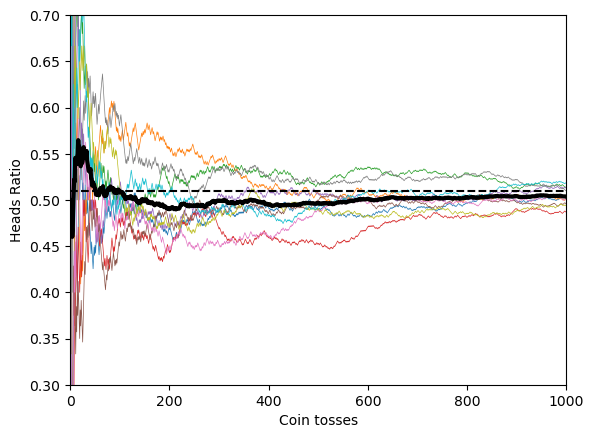

In [4]:
probability = .51 # probability of heads vs. tails.
n = 1000 # number of coin tosses
members = 10 # number of ensemble members
fullResults = np.zeros(n) # create storage array for actual flips
headRatio = np.zeros((n,members)) # create storage array for ratio of heads to tails
for j in range(members): # loop over all the ensemble members
    for i in range(n):    # loop over all the required tosses
        # generate one random sample of 0 or 1 with given probability
        fullResults[i] = np.random.binomial(1,probability) 
        headRatio[i,j] = np.average(fullResults[0:i+1]) # calculate the ratio up to this toss
plt.plot(np.arange(n),headRatio,linewidth=.5) # plot the ratio for all ensemble members
# for each toss calculate the average of the ratio over all ensemble members    
for i in range(n):
    fullResults[i] = np.average(headRatio[i,:])
# plot the average with a thick black line    
plt.plot(np.arange(n),fullResults,'k',linewidth=3)
# plot the given probability   
plt.plot(np.arange(n),probability*np.ones(n),'k--')
plt.ylim(.3,.7) # set the y limits
plt.xlim(0,n) # set the x limits
plt.ylabel('Heads Ratio') # set the x label
plt.xlabel('Coin tosses'); # set the y label

## Voting Classifiers and Decision Trees

The same approach can be used to improve the accuracy of an ensemble of classifiers, provided the classifiers are largely independent of each other, i.e., they are not making the same mistakes. For a voting classifier this can occur if we use completely different classifiers on the training data. For example, consider we have a Logistic Regression Classifier, a Support Vector Classifier and a Decision Tree Classifier being trained on the same data set. As they are being trained on the same data, they are not completely independent, however as the algorithms are significantly different there is relatively low correlation between their errors. These can then be used to create an improved accuracy aggregator.

The sklearn aggregator `VotingClassifier` takes different classifiers and aggregates the results to produce a new classification. This is achieved using either `hard` or `soft` voting. For hard voting all the ensemble is polled and the classification with the most votes is chosen. For soft voting the average probability for each class is taken over the ensemble, and the class with the highest probability is chosen.

For the example below the Voting Classifier is applied to the sklearn `moons` data, which produces two interleaved half-moons. The three members of the ensemble are Logistic Regression Classifier, Support Vector Classifier and Decision Tree Classifier. By default Support Vector Classifier do not output probabilities, so to use soft voting we need get the classifier to create probabilities.  By using the Voting Classifier an accuracy of 93.3% is achieved, whereas the best component of the ensemble is Support Vector Classifier with an accuracy of 92%.

The Voting Classifier does not always give better results than any member of the ensemble, however this can often occur.

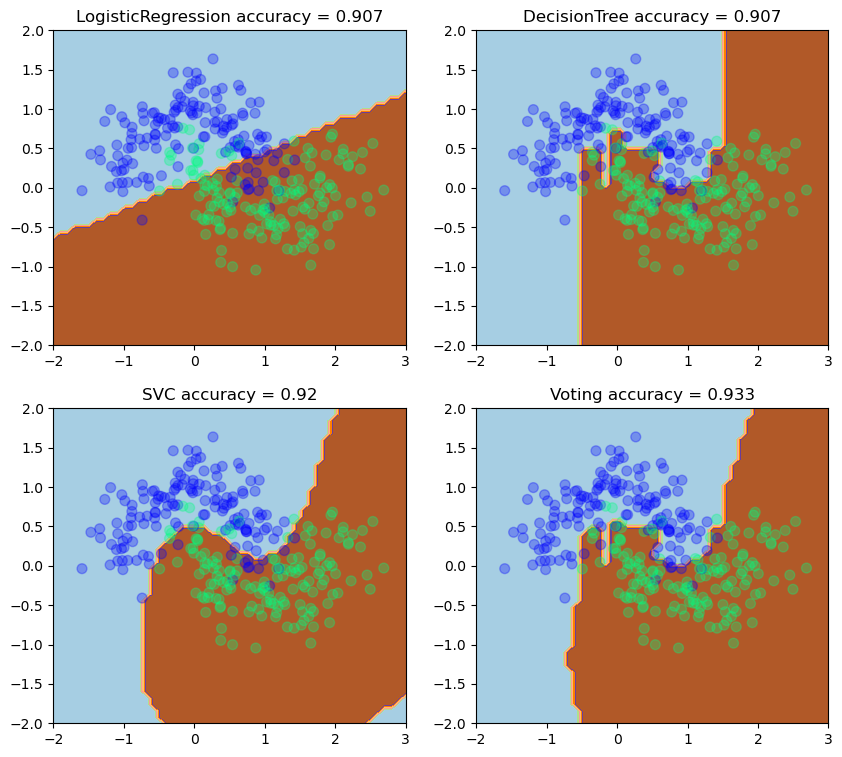

In [23]:
# make binary classification of two intersecting half moons, with specified noise 
X, y = make_moons(n_samples=300, noise=0.25, random_state = 42) 
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# instantatiate the logistic regression, decision tree and support vector classifiers
# get SVC to calculate probabilities
log_clf = LogisticRegression(random_state=0)
dtc_clf = DecisionTreeClassifier(random_state=0)
svm_clf = SVC(probability=True, random_state=0)
# instantatiate the voting classifier with our three standard classifiers
# and use soft voting (probability based)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('dt', dtc_clf), ('svc', svm_clf)],
                             voting = 'soft')
voting_clf.fit(X_train,y_train) # fit the training data to all the classifiers
# initialise a set of 2 by 2 subplots
fig, axs = plt.subplots(2,2,figsize=(10,9))
# create x and y grid for plotting the decision boundaries
xx, yy = np.meshgrid(np.linspace(-2,3), np.linspace(-2,2))

names = ('LogisticRegression','DecisionTree','SVC','Voting') # set the names for the plot titles
# loop over k, the classifiers and the classifier names
for k, clf, name in zip(range(4),(log_clf, dtc_clf, svm_clf, voting_clf),names):
    i = k//2 # integer division, rounded down to nearest integer
    j = k%2 # calculate remainder of k//2
    clf.fit(X_train, y_train) # fit the training data to each classifier
    y_pred = clf.predict(X_test) # use the classifier to predict results for the testing features
    # contour plot of the decision boundaries for this classifier
    plt_decision_boundaries(clf, xx, yy, axs[i,j], fill=True) 
    # scatter plot of the features coloured by the target values
    axs[i,j].scatter(X[:,0], X[:,1], c=y, s=50, cmap='winter', alpha=0.3); 
    accuracy = np.round(accuracy_score(y_test, y_pred),3) # calculate the accuracy score
    # add the depth and accuracy to the title
    axs[i,j].set_title('{0} accuracy = {1}'.format(name, accuracy)) 

To consider the application of ensemble methods to DTC we import the wine dataset, which was used in the previous notebook. This consists of 178 samples, with 13 features and one target consisting of three classes.

In [24]:
# read the data from the csv file into a pandas dataframe
df = pd.read_csv("wine_data.csv", header = None, 
                names = ['Class','Alcohol','MalicAcid','Ash','Alcalinity','Mg',
                         'Phenols','Flavanoids','Nonflavanoids',
                         'Proanthocyanins','Colour','Hue','ProteinConcentration','Proline']) 
df.shape # print the shape of the dataframe

(178, 14)

Initially we again consider a two feature model using the `Flavanoids` and `Proline` columns.

In [25]:
rdf = df[['Class','Flavanoids','Proline']] # create a smaller dataframe with only these columns
X = rdf.drop('Class', axis = 1) # drop the target variable for the features
y = rdf['Class'] # create a target dataframe

The DTC have high variance and consequently overfit the data. This can be seen by plotting the decision boundaries for four runs of the DTC. Each uses the same training set, but the features are randomly sampled for splitting at each node by setting `max_features=1` (recall there are only two features for this model). We obtain that DTC have a high variance, with some performing poorly and some quite well.

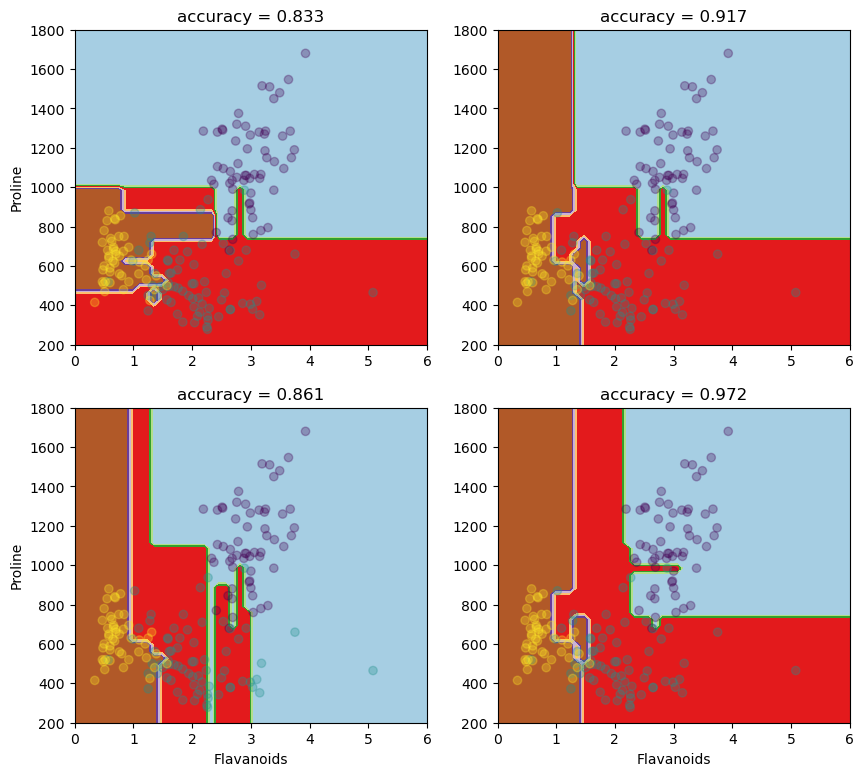

In [26]:
fig, axs = plt.subplots(2,2,figsize=(10,9)) # initialise the plots and axes for 2 by 2 subfigures
# create x and y grid for plotting the decision boundaries
xx, yy = np.meshgrid(np.linspace(0,6), np.linspace(200,1800))
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
cdt = {}  # dict to store the fitted trees for voting classifier
for k in range(4): # loop over 0 to 3
    i = k//2 # integer division, rounded down to nearest integer
    j = k%2 # calculate remainder of k//2
    # fit the training data to the DTC and randomly use one feature at each node for splitting
    df_dtc = DecisionTreeClassifier(max_features=1).fit(X_train, y_train)
    # axs[i,j] is (i,j) set of the axes defined above
    # contour plot of the decision boundaries for this classifier
    plt_decision_boundaries(df_dtc,xx,yy,axs[i,j]) 
    # scatter plot of the two features, coloured based on the target, alpha set the transperancy
    axs[i,j].scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
    Y_pred = df_dtc.predict(X_test) # calculate the predicted values
    accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
    # add the depth and accuracy to the title
    axs[i,j].set_title('accuracy = {0}'.format(accuracy)) 
    # only print axis labels on the left and bottom
    if i == 1:
        axs[i,j].set_xlabel('Flavanoids')
    if j == 0:
        axs[i,j].set_ylabel('Proline')
    # for each value of k store the decision tree to be used with the voting classifier
    cdt[f'df_dtc{k}'] = df_dtc

The four runs of the DTC can now be input to the Voting Classifier. Using soft voting the aggregator produces an accuracy which is better than any member of the ensemble. Similarly the decision boundaries appear to be much less sensitive to the training data, indicating a reduction in the variance of the model.

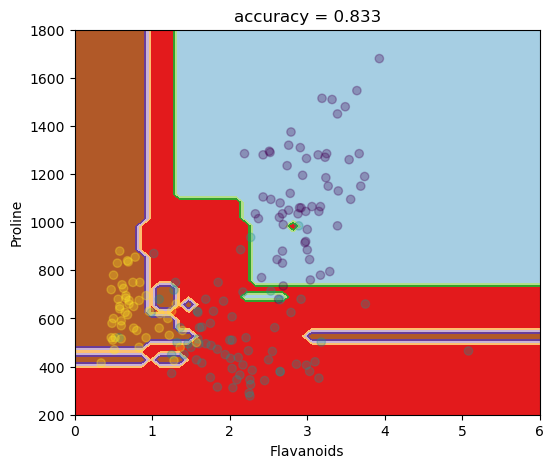

In [27]:
fig, ax = plt.subplots(figsize=(6,5)) # initialise the plots and axes
# instantatiate the voting classifier with the four DTC defined in the previous cell 
# and use soft voting (probability based)
voting_clf = VotingClassifier(estimators=list(cdt.items()), voting='soft')
voting_clf.fit(X_train,y_train) # fit the training data to the classifiers
plt_decision_boundaries(voting_clf,xx,yy) # contour plot of the decision boundaries for this classifier
# scatter plot of the two features, coloured based on the target, alpha set the transperancy
plt.scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
Y_pred = voting_clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
# add the depth and accuracy to the title
plt.title('accuracy = {0}'.format(accuracy)) 
plt.xlabel('Flavanoids') # x axis label
plt.ylabel('Proline'); # y axis label

## Random Forests

RFC generalise this process by incorporating random sampling of the training data for the ensemble of DTC. You can think of this as a new call to `test_train_split` before creating each DTC. There are two ways to do this: bagging and pasting. Bagging (Bootstrap Aggregating) does this by random sampling of instances with replacement. For example, we sample coloured balls from an urn, record the colour and put the ball back in the urn. Hence in each sample instances can possibly occur multiple times. Pasting does the random sampling of instances without replacement, and therefore in each sample instances can only occur once. For example, Lotto numbers are sampled without replacement. Each predictor is then trained on their particular random sample, and then the classification is chosen based on the most frequent prediction of the estimators (hard voting). The aggregator then has similar bias as the original model, but lower variance. Bagging generally leads to better models, as it has lower variance than pasting. 

For a general classifier, we can use the `sklearn` function `BaggingClassifier`. However, for Decision Trees it is easier to use the function `RandomForestClassifier` which combines the `BaggingClassifier` with the `DecisionTreeClassifier`. `RandomForestClassifier` takes as arguments, the arguments of both of these functions. The most important arguments for RFC are `n_estimators`, `max_samples` and `bootstrap`: 

* `n_estimators` defines the size of the ensemble, and increasing this reduces the variance of the model. 
* `max_samples` defines how many samples are used for each estimator. This can be a positive integer, which directly gives the sample size, or a decimal number between 0 and 1, which defines the fraction of the number of instances to be used for the sample size. Decreasing this will increase the randomness of the individual estimators, and reduce the variance of the final model. 
* `bootstrap` is True to use bagging and False to use pasting. The default behaviour is bagging.

In the example below we set the number of ensemble members to 200 and fraction of samples for each model to a half. These could also be combined with hyper-parameters for `DecisionTreeClassifier`, such as `max_features` or `max_depth`. This gives an accuracy of which is at least as good as the ensemble members above and the voting classifier. However, the decision boundaries are much more regular, indicating that the variance of the model is again significantly decreased.

The optimal hyper-parameters could then be obtained using `GridSearchCV`.

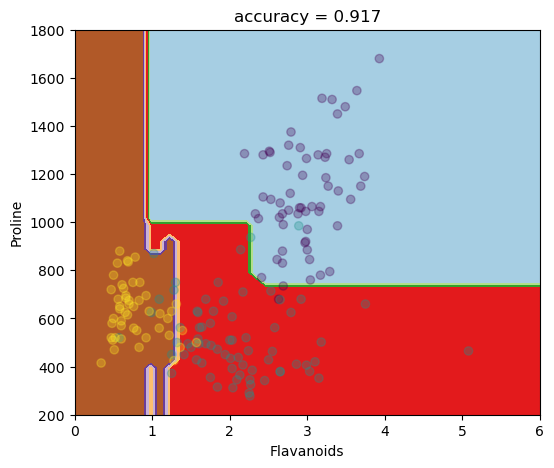

In [28]:
fig, ax = plt.subplots(figsize=(6,5)) # initialise the plots and axes
# instantatiate the RFC with 200 ensemble members and randomly use only half the training data
# for each ensemble members
clf = RandomForestClassifier(n_estimators=200, max_samples=.5).fit(X_train, y_train)
plt_decision_boundaries(clf,xx,yy) # contour plot of the decision boundaries for this classifier
# scatter plot of the two features, coloured based on the target, alpha set the transperancy
plt.scatter(X['Flavanoids'], X['Proline'], c=y, alpha=0.3);
Y_pred = clf.predict(X_test) # calculate the predicted values
accuracy = np.round(accuracy_score(y_test, Y_pred),3) # calculate the accuracy score
# add the depth and accuracy to the title
plt.title('accuracy = {0}'.format(accuracy)) 
plt.xlabel('Flavanoids') # x axis label
plt.ylabel('Proline'); # y axis label

## Feature Importance

One important property of RFC is that they allow the user to easily measure the relative importance of each of the data features, by accessing the `feature_importance_` variable of the model. This is the relative weight of the feature in reducing impurity in tree nodes. The weights for all features sum to one. For example, this could be used in feature selection to reduce the number of features which are input to the model.

To understand this we consider the full set of features for the wine classification data. The accuracy of RFC for the training data is 97.2%. We see the most important features are `Colour`, `ProteinConcentration`, `Flavanoids` and `Proline`.

In [29]:
# use the full wine data set
X = df.drop('Class', axis = 1) # drop the target variable for the features
y = df['Class'] # create a target dataframe
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
Y_pred = clf.predict(X_test)  # calculate the predicted values
# print the accuracy of the RFC
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, Y_pred),3)))
# loop over all the names and feature importance and print both
for name, score in zip(X.columns, clf.feature_importances_):
    print(name,np.round(score,3))

Accuracy 0.972
Alcohol 0.107
MalicAcid 0.022
Ash 0.012
Alcalinity 0.017
Mg 0.021
Phenols 0.069
Flavanoids 0.14
Nonflavanoids 0.017
Proanthocyanins 0.027
Colour 0.182
Hue 0.083
ProteinConcentration 0.143
Proline 0.159


Recall from the previous notebook that there is a significant correlation between the features `ProteinConcentration` and `Flavanoids`. Therefore we can set up a RFC with the three features `Colour`, `Flavanoids` and `Proline`. The resultant model has equivalent accuracy as the full model.

In [11]:
rdf = df[['Class','Flavanoids','Proline','Colour']] # create a smaller dataframe with only these columns
X = rdf.drop('Class', axis = 1) # drop the target variable for the features
y = rdf['Class'] # create a target dataframe
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

Y_pred = clf.predict(X_test) # calculate the predicted values
# print the accuracy of the RFC
print(f'Accuracy {accuracy_score(y_test, Y_pred):.3f}')

Accuracy 0.972


In [13]:
y

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Class, Length: 178, dtype: int64

In [19]:
Y_pred

array([1, 3, 2, 1, 2, 2, 1, 3, 2, 2, 3, 3, 1, 2, 3, 2, 1, 1, 3, 1, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1], dtype=int64)

## Random Forest Regressor

Random Forests can be utilised for Regression as well. This is clear, since Decision Trees can be utilised for Regression, and Random Forests are simply ensembles of Decision Trees.

Random Forest Regression can be implemented via `sklearn` through the `RandomForestRegressor` class.